<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_21_40_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [34]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [37]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [38]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [39]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [40]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [41]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [42]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 10

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)
        median = torch.median(fisher_matrix[num_task][name]) # 中位數
        select_idx = torch.where(fisher_matrix[num_task][name] < median)
        fisher_matrix[num_task][name][select_idx] = 0 # 小於中位數 -> 變成零
    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [43]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [44]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.8203, Loss:  0.0033
Epoch	2	Acc:  0.8910, Loss:  0.0017
Epoch	3	Acc:  0.9035, Loss:  0.0014
Epoch	4	Acc:  0.9101, Loss:  0.0013
Epoch	5	Acc:  0.9145, Loss:  0.0012
Epoch	6	Acc:  0.9171, Loss:  0.0012
Epoch	7	Acc:  0.9195, Loss:  0.0011
Epoch	8	Acc:  0.9212, Loss:  0.0011
Epoch	9	Acc:  0.9223, Loss:  0.0011
Epoch	10	Acc:  0.9236, Loss:  0.0011
Task 0 Acc:  0.9244, Loss:  0.0011
Task 1 Acc:  0.1370, Loss:  0.0263

Task 1 Start!
Epoch	1	Acc:  0.3376, Loss:  0.0132
Epoch	2	Acc:  0.5949, Loss:  0.0075
Epoch	3	Acc:  0.6640, Loss:  0.0063
Epoch	4	Acc:  0.6940, Loss:  0.0058
Epoch	5	Acc:  0.7102, Loss:  0.0055
Epoch	6	Acc:  0.7212, Loss:  0.0053
Epoch	7	Acc:  0.7267, Loss:  0.0051
Epoch	8	Acc:  0.7327, Loss:  0.0050
Epoch	9	Acc:  0.7355, Loss:  0.0049
Epoch	10	Acc:  0.7391, Loss:  0.0049
Task 0 Acc:  0.6769, Loss:  0.0043
Task 1 Acc:  0.7488, Loss:  0.0034



 - Task 0

Accuracy 0.6769
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.82      0.81      0.81       980
     1 - one       0.97      0.83      0.90      1135
     2 - two       0.69      0.75      0.72      1032
   3 - three       0.62      0.79      0.69      1010
    4 - four       0.32      0.73      0.44       982
    5 - five       0.69      0.34      0.45       892
     6 - six       0.87      0.81      0.84       958
   7 - seven       0.96      0.71      0.81      1028
   8 - eight       0.69      0.48      0.57       974
    9 - nine       0.76      0.47      0.58      1009

    accuracy                           0.68     10000
   macro avg       0.74      0.67      0.68     10000
weighted avg       0.74      0.68      0.69     10000



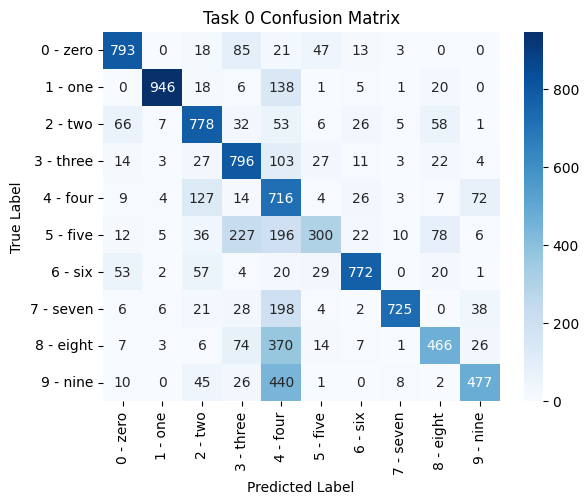

In [45]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.7488
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.85      0.92      0.88       980
     1 - one       0.87      0.93      0.90      1135
     2 - two       0.67      0.57      0.61      1032
   3 - three       0.71      0.76      0.73      1010
    4 - four       0.82      0.81      0.81       982
    5 - five       0.50      0.45      0.47       892
     6 - six       0.84      0.79      0.81       958
   7 - seven       0.83      0.80      0.81      1028
   8 - eight       0.59      0.62      0.61       974
    9 - nine       0.75      0.79      0.77      1009

    accuracy                           0.75     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.75      0.75      0.75     10000



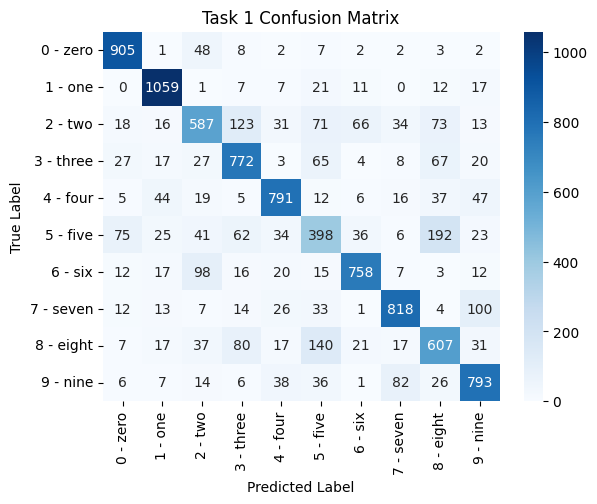

In [46]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 0.01603 and it's parameter diff is 0.00568
Max Parameter diff is 1.09875 and it's fisher is 0.00006
fisher > parameter diff: 63
fisher <= parameter diff: 721
fisher == 0: 391/784(0.50%)


<Figure size 640x480 with 0 Axes>

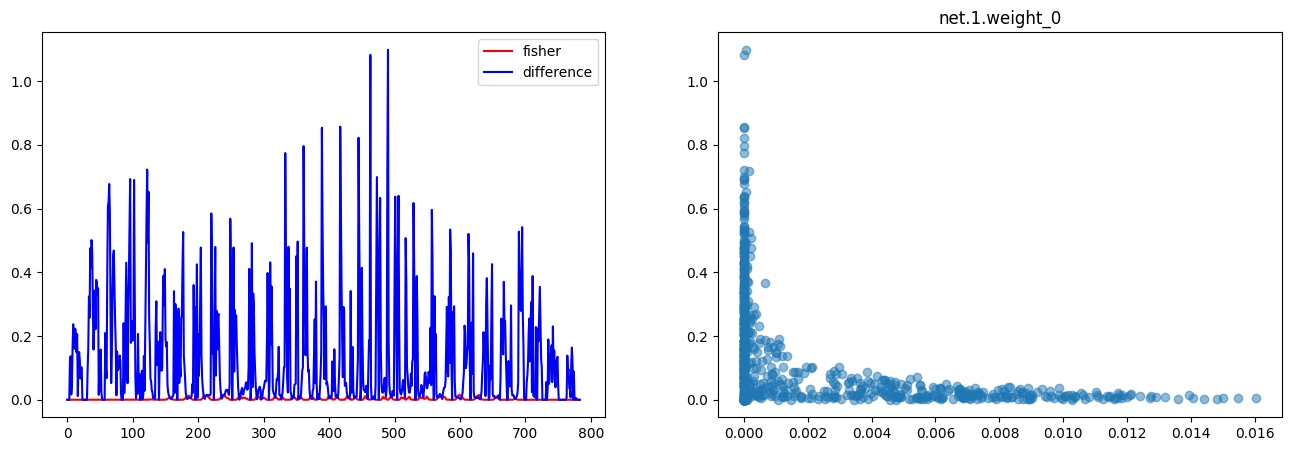

Max fisher is 0.05653 and it's parameter diff is 0.00122
Max Parameter diff is 1.19579 and it's fisher is 0.00000
fisher > parameter diff: 51
fisher <= parameter diff: 733
fisher == 0: 495/784(0.63%)


<Figure size 640x480 with 0 Axes>

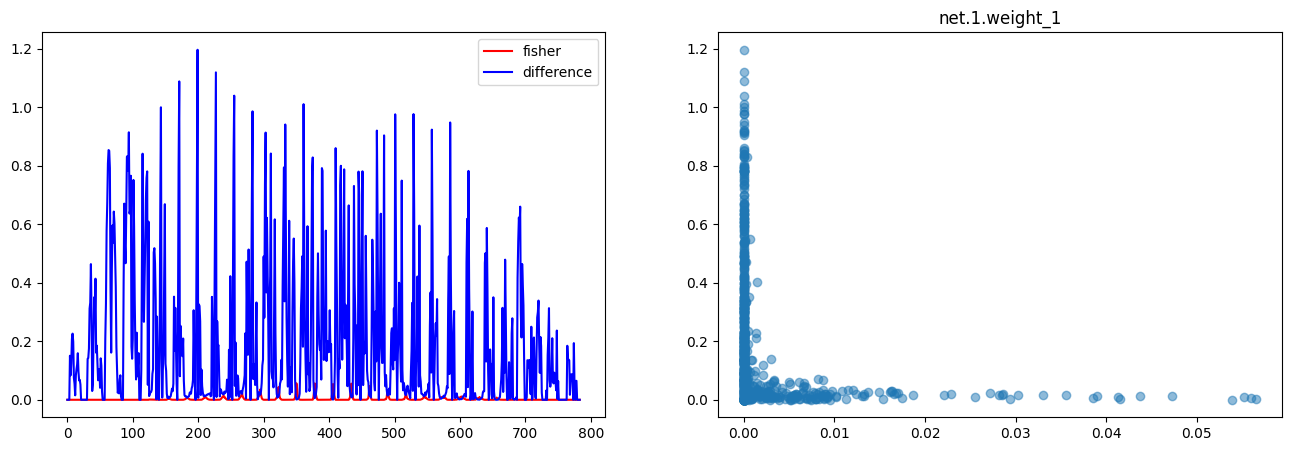

Max fisher is 0.08803 and it's parameter diff is 0.00604
Max Parameter diff is 1.10440 and it's fisher is 0.00000
fisher > parameter diff: 226
fisher <= parameter diff: 558
fisher == 0: 334/784(0.43%)


<Figure size 640x480 with 0 Axes>

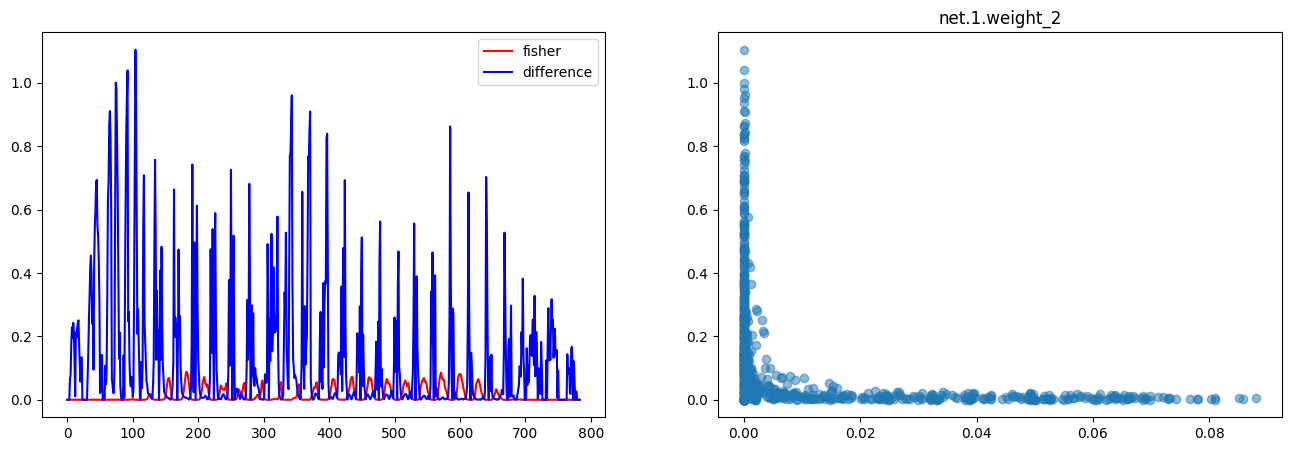

Max fisher is 0.01717 and it's parameter diff is 0.00143
Max Parameter diff is 1.10500 and it's fisher is 0.00000
fisher > parameter diff: 41
fisher <= parameter diff: 743
fisher == 0: 388/784(0.49%)


<Figure size 640x480 with 0 Axes>

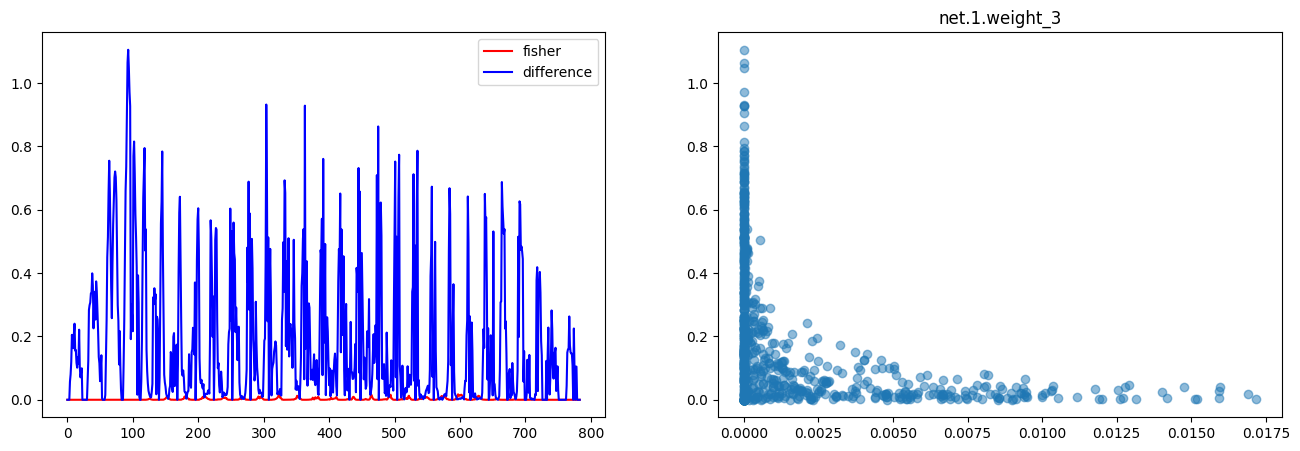

Max fisher is 0.01296 and it's parameter diff is 0.03452
Max Parameter diff is 1.05078 and it's fisher is 0.00000
fisher > parameter diff: 9
fisher <= parameter diff: 775
fisher == 0: 379/784(0.48%)


<Figure size 640x480 with 0 Axes>

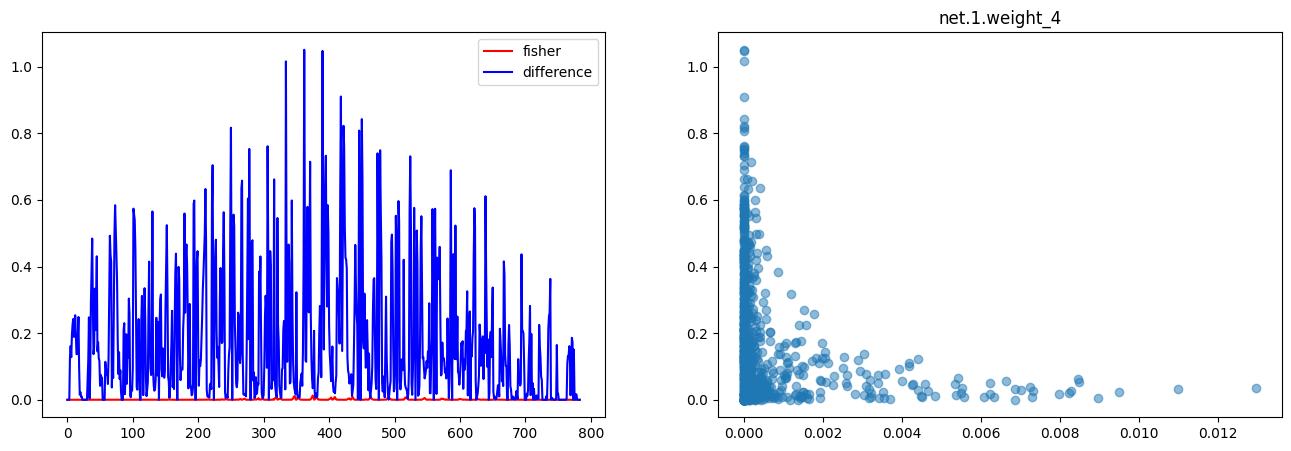

Max fisher is 0.05574 and it's parameter diff is 0.00736
Max Parameter diff is 1.23633 and it's fisher is 0.00000
fisher > parameter diff: 110
fisher <= parameter diff: 674
fisher == 0: 360/784(0.46%)


<Figure size 640x480 with 0 Axes>

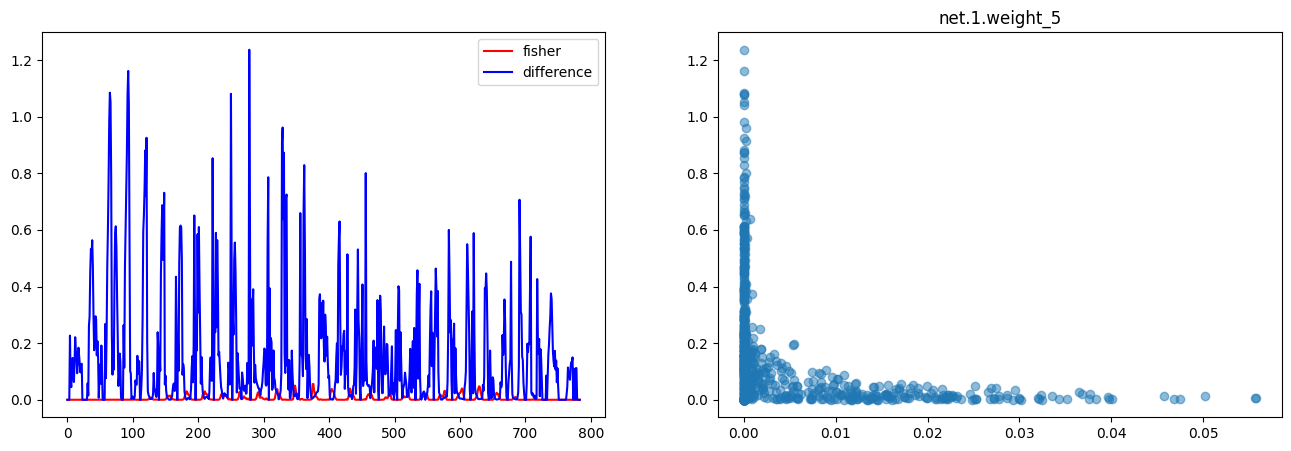

Max fisher is 0.02276 and it's parameter diff is 0.00389
Max Parameter diff is 0.97820 and it's fisher is 0.00000
fisher > parameter diff: 70
fisher <= parameter diff: 714
fisher == 0: 403/784(0.51%)


<Figure size 640x480 with 0 Axes>

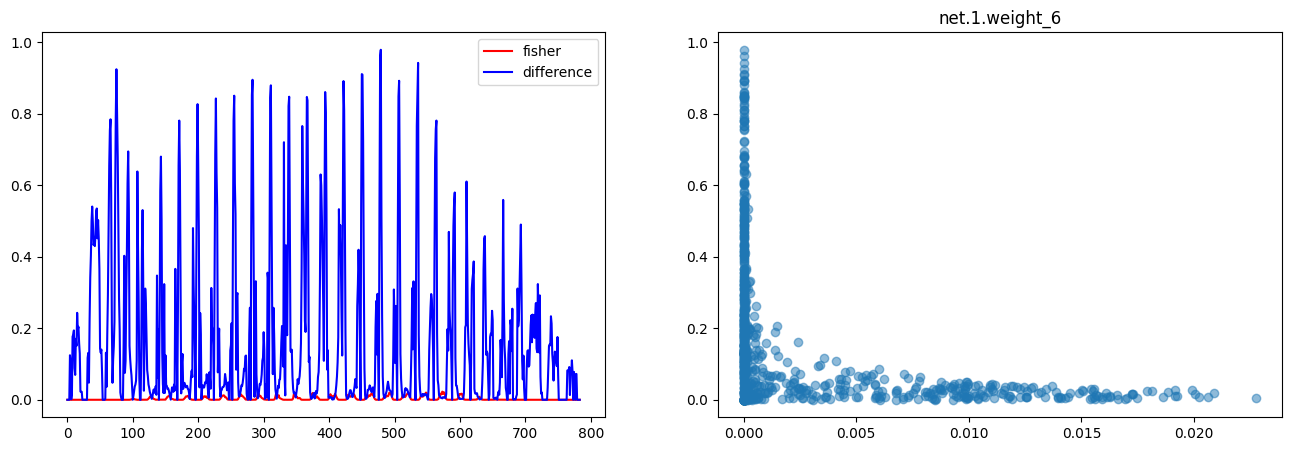

Max fisher is 0.01944 and it's parameter diff is 0.02264
Max Parameter diff is 1.05922 and it's fisher is 0.00000
fisher > parameter diff: 33
fisher <= parameter diff: 751
fisher == 0: 389/784(0.50%)


<Figure size 640x480 with 0 Axes>

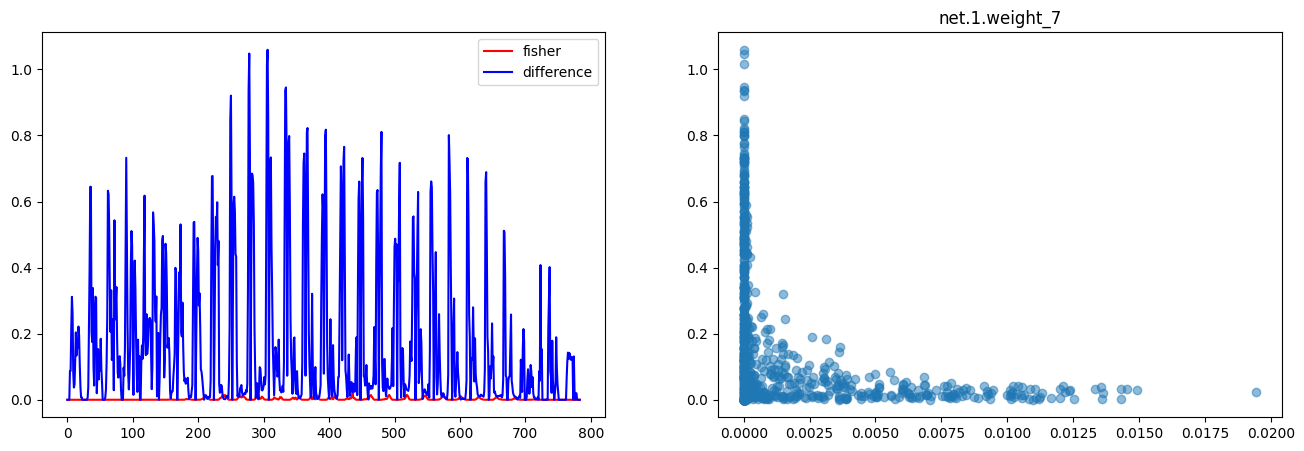

Max fisher is 0.33322 and it's parameter diff is 0.00016
Max Parameter diff is 1.19430 and it's fisher is 0.00000
fisher > parameter diff: 282
fisher <= parameter diff: 502
fisher == 0: 368/784(0.47%)


<Figure size 640x480 with 0 Axes>

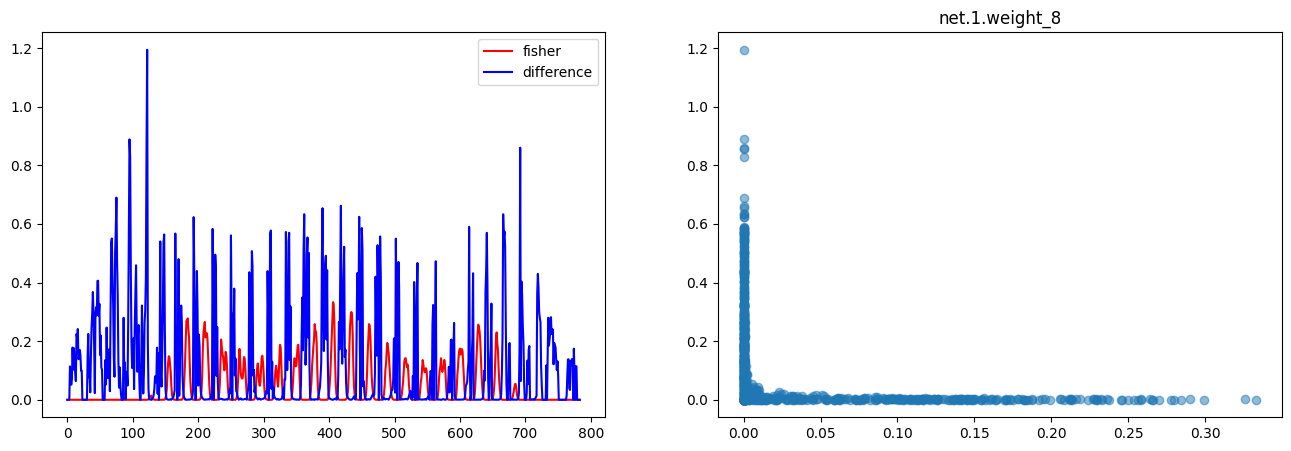

Max fisher is 0.04249 and it's parameter diff is 0.00968
Max Parameter diff is 1.15762 and it's fisher is 0.00000
fisher > parameter diff: 101
fisher <= parameter diff: 683
fisher == 0: 412/784(0.53%)


<Figure size 640x480 with 0 Axes>

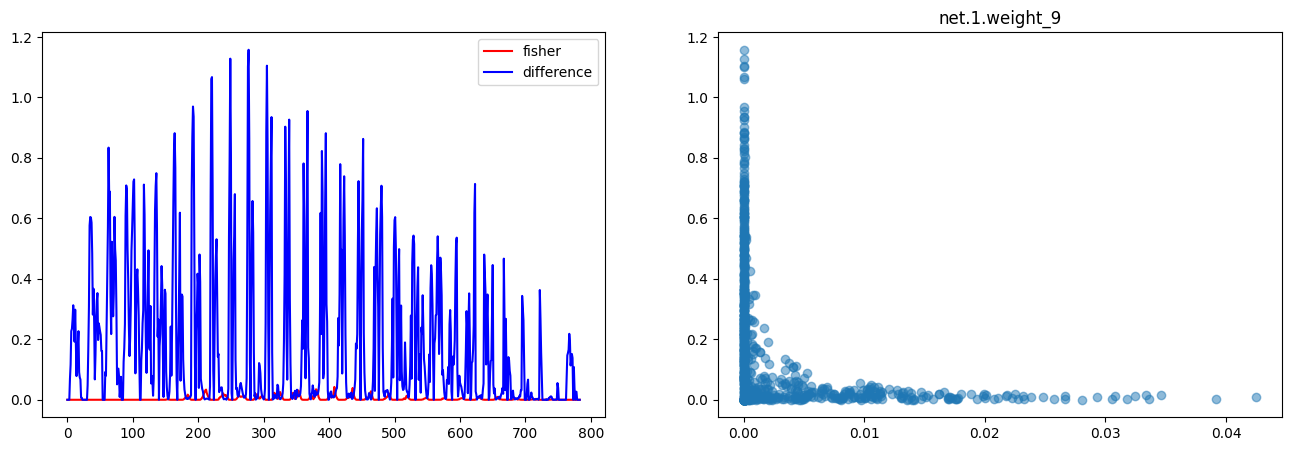


net.1.bias
torch.Size([10])
Max fisher is 1.29078 and it's parameter diff is 0.00037
Max Parameter diff is 0.66280 and it's fisher is 0.00000
fisher > parameter diff: 6
fisher <= parameter diff: 4
fisher == 0: 4/10(0.40%)


<Figure size 640x480 with 0 Axes>

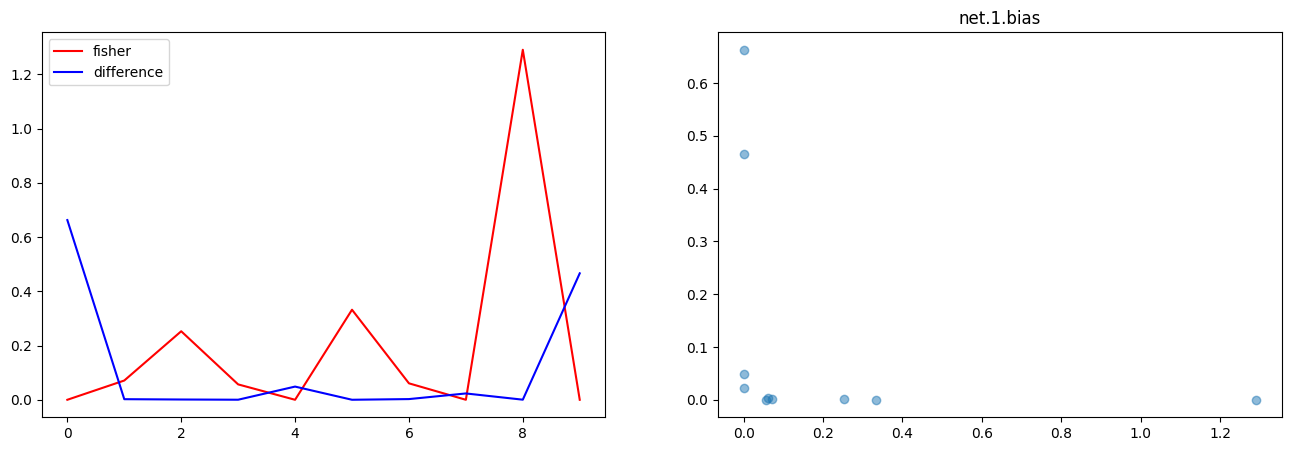

In [47]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Max Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))
  print('fisher == 0: {}/{}({:.2f}%)'.format((fisher == 0).sum(), fisher.shape[0], (fisher == 0).sum() / fisher.shape[0]))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [48]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-25_23_27_22
